# **Third Assignment: Homophobic tweets classifier**

### - Armando Miguel Tapia Meza
### - Erick Jose Ruiz Acosta

In [1]:
from logic.text_processing import TextProcessing
from logic.lexical_vectorizer import LexicalVectorizer
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
from logic.stratified_sampling import random_stratified_sampling
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

from root import DIR_INPUT

In [2]:
text_procesing = TextProcessing(lang='es')

## **Preprocesamiento**

### Descripción del contenido de las columnas

- Id : Identificación unica del tweet
- Date : Tiempo universal coordinado (UTC) en el que el tweet fue creado
- Tweet : Texto en formato UTF8 de la actualización de estado
- Event : Indica si un tweet promueve o no la homofobia (1 para si y 0 para no)

### se cargan los datos

In [3]:
df = pd.read_csv('{0}{1}.csv'.format(DIR_INPUT, 'homofobia'), sep=',')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      440 non-null    int64 
 1   Date    440 non-null    object
 2   Tweet   440 non-null    object
 3   Event   440 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 13.9+ KB


In [5]:
df.head()

,Id,Date,Tweet,Event
0,1457324921235939330,Sun Nov 07 12:31:51 +0000 2021,1 millon de presupuesto por arepera para 10 a...,1
1,1456239809098289161,Thu Nov 04 12:40:00 +0000 2021,Ahh ya entiendo eres arepera,1
2,1457071812920053760,Sat Nov 06 19:46:05 +0000 2021,creo que deberiamos hacer mas canciones que ...,0
3,1451247469480796163,Thu Oct 21 18:02:14 +0000 2021,Que tristeza tan grande marica uno bien ilusi...,0
4,1457712681859878924,Mon Nov 08 14:12:41 +0000 2021,"""Los maricones no deberían estar en la Guardia...",1


In [6]:
df.duplicated().sum()

0

In [7]:
#verificacion de valores faltantes por columna
df.isna().sum()

Id       0
Date     0
Tweet    0
Event    0
dtype: int64

In [8]:
# estadisticos categoricos para la columna objetivo 
df['Event'] = df['Event'].astype(str)
df['Event'].describe()

count     440
unique      2
top         1
freq      259
Name: Event, dtype: object

### Gráficas y distribuciones de frecuencia

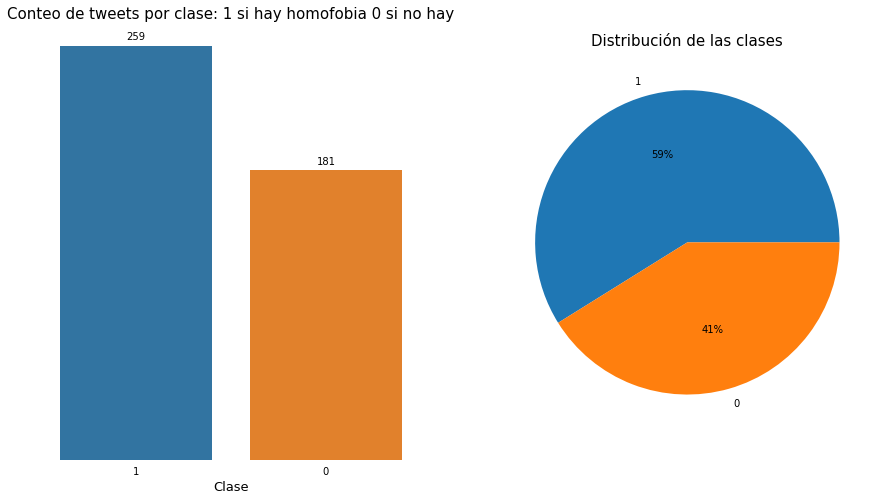

In [10]:
fig, axes = plt.subplots(1,2,figsize=(15,8))
pos = np.arange(len(df['Event'].unique()[:2]))
bar = sns.countplot(ax=axes[0],x='Event',data=df ,order = df['Event'].value_counts().index)
axes[0].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
for p in bar.patches:
    bar.annotate(p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
for pos in ['right', 'top', 'bottom', 'left']:
    axes[0].spines[pos].set_visible(False)
bar.set_ylabel('')
bar.set_xlabel('Clase', size=13)
bar.set_title('Conteo de tweets por clase: 1 si hay homofobia 0 si no hay', size=15)
pie = axes[1].pie(x=df['Event'].value_counts(),labels = df['Event'].unique()[:2],autopct='%.0f%%')
_=axes[1].set_title('Distribución de las clases', size=15)

### Aplicamos el metodo transformer de la clase TextProcesing

In [91]:

df['Clean_tweet'] = [text_procesing.transformer(row) for row in df['Tweet'].tolist()]
df

,Id,Date,Tweet,Event,Clean_tweet
0,1457324921235939330,Sun Nov 07 12:31:51 +0000 2021,1 millon de presupuesto por arepera para 10 a...,1,millon de presupuesto por arepera para anos no...
1,1456239809098289161,Thu Nov 04 12:40:00 +0000 2021,Ahh ya entiendo eres arepera,1,ahh ya entiendo eres arepera
2,1457071812920053760,Sat Nov 06 19:46:05 +0000 2021,creo que deberiamos hacer mas canciones que ...,0,creo que deberiamos hacer mas canciones que ha...
3,1451247469480796163,Thu Oct 21 18:02:14 +0000 2021,Que tristeza tan grande marica uno bien ilusi...,0,que tristeza tan grande marica uno bien ilusio...
4,1457712681859878924,Mon Nov 08 14:12:41 +0000 2021,"""Los maricones no deberían estar en la Guardia...",1,los maricones no deberian estar en la guardia ...
...,...,...,...,...,...
435,1462118599271727104,Sat Nov 20 18:00:13 +0000 2021,Yo sí shippeo este matrimonio gay interracial ...,0,yo si shippeo este matrimonio gay interracial ...
436,1455272456911048705,Mon Nov 01 20:36:06 +0000 2021,Yo tenia dudas de que este man era cagasten pe...,1,yo tenia dudas de que este man era cagasten pe...
437,1457067791601872906,Sat Nov 06 19:30:07 +0000 2021,¿Entonces uno puede ser culpable e inocente? ¿...,0,entonces uno puede ser culpable e inocente un ...
438,1461842014010585093,Fri Nov 19 23:41:10 +0000 2021,¿les dejaría de gustar un chico por ser afemin...,0,les dejaria de gustar un chico por ser afemina...


### Dividimos el dataset usando muestreo aleatorio estratificado

In [92]:
x_train, y_train, x_test, y_test = random_stratified_sampling(df,y='Event',test_size=0.2)

### verificacion del balanceo de las clases tanto para las pruebas como para el entrenamiento

In [93]:

y_test.value_counts()

1    44
0    44
Name: Event, dtype: int64

In [94]:
y_train.value_counts()

1    215
0    137
Name: Event, dtype: int64

### Vista final del dataset despues del preprocesamiento

In [95]:
x_train

,Id,Date,Tweet,Clean_tweet
0,1456239809098289161,Thu Nov 04 12:40:00 +0000 2021,Ahh ya entiendo eres arepera,ahh ya entiendo eres arepera
1,1457071812920053760,Sat Nov 06 19:46:05 +0000 2021,creo que deberiamos hacer mas canciones que ...,creo que deberiamos hacer mas canciones que ha...
2,1451247469480796163,Thu Oct 21 18:02:14 +0000 2021,Que tristeza tan grande marica uno bien ilusi...,que tristeza tan grande marica uno bien ilusio...
3,1457712681859878924,Mon Nov 08 14:12:41 +0000 2021,"""Los maricones no deberían estar en la Guardia...",los maricones no deberian estar en la guardia ...
4,1462547214446833665,Sun Nov 21 22:23:23 +0000 2021,#CuartoMilenio Yo ya me he perdido chicos ¿una...,hastag yo ya me he perdido chicos una psicofon...
...,...,...,...,...
347,1450652629487558661,Wed Oct 20 02:38:33 +0000 2021,Ya vas tu con tus vainas de cagasten,ya vas tu con tus vainas de cagasten
348,1451217720792526858,Thu Oct 21 16:04:01 +0000 2021,Yo no lo veo homofobo. Una es heterosexual y l...,yo no lo veo homofobo. una es heterosexual y l...
349,1462118599271727104,Sat Nov 20 18:00:13 +0000 2021,Yo sí shippeo este matrimonio gay interracial ...,yo si shippeo este matrimonio gay interracial ...
350,1457067791601872906,Sat Nov 06 19:30:07 +0000 2021,¿Entonces uno puede ser culpable e inocente? ¿...,entonces uno puede ser culpable e inocente un ...


## **Extraccion de caracteristicas**

### Usaremos TF-IDF y vectorizacion lexica a traves de union de caracteristicas

In [96]:
tfidf_vector = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
lexical_vectorizer = LexicalVectorizer(lang='es', text_processing=text_procesing)

In [97]:
features_union = FeatureUnion([
            ('tfidf_vector', tfidf_vector),
            ('lexical_vector', lexical_vectorizer)
        ])

In [98]:
features_union.fit_transform(x_train['Clean_tweet'])

<352x1057 sparse matrix of type '<class 'numpy.float64'>'
	with 8164 stored elements in Compressed Sparse Row format>

In [99]:
x_train = features_union.transform(x_train['Clean_tweet'])
x_test = features_union.transform(x_test['Clean_tweet'])

In [100]:
x_train

<352x1057 sparse matrix of type '<class 'numpy.float64'>'
	with 8164 stored elements in Compressed Sparse Row format>

### Nos aseguramos de que los dataset con los target de prueba y de entrenamiento esten balanceados

In [101]:
print('Muestra de entrenamiento:', sorted(Counter(y_train).items()))

Muestra de entrenamiento: [('0', 137), ('1', 215)]


In [102]:
print('Muestra de pruebas:', sorted(Counter(y_test).items()))

Muestra de pruebas: [('0', 44), ('1', 44)]


### Aplicaremos Oversampling para balancear las clases en y_train

In [103]:
ros_train = RandomOverSampler(random_state=1000)
x_train, y_train = ros_train.fit_resample(x_train, y_train)

In [104]:
print('Muestra de entrenamiento:', sorted(Counter(y_train).items()))

Muestra de entrenamiento: [('0', 215), ('1', 215)]


## **Entrenamiento**

### Clasificadores

- Random Forest
- Logistic Regression
- SVM

In [105]:
import multiprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [106]:
class Classifiers(object):
    cores = multiprocessing.cpu_count() - 1
    dict_classifiers = dict()
    dict_classifiers['SVM'] = svm.SVC(kernel='poly', degree=3, C=1)
    dict_classifiers['RandomForest'] = RandomForestClassifier(n_estimators=100,max_features='auto',max_depth=None,min_samples_leaf=1,n_jobs=cores)
    dict_classifiers['LogReg'] = LogisticRegression(penalty='l2', C=1.0)

In [107]:
import csv
from collections import Counter
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit


from root import DIR_RESULTS

In [108]:
#Nombres de las columnas a crear en el archivo de salida
fieldnames = ('model_name', 'classifier', 'accuracy_train', 'accuracy_test', 'classification_report', 'date')

#Extraemos la fecha y hora en la que se realiza la iteración 
date_file = datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")


#Instanciamos el objeto para aplicar validación cruzada 
k_fold = ShuffleSplit(n_splits=10, test_size=0.25, random_state=42)
print('\n')
print('\t\t - train:', sorted(Counter(y_train).items()))
print('\t\t - test:', sorted(Counter(y_test).items()))

print('\t+ Training...')
print('\n')
result = {}

#Creación del directorio de resultados
directory = f"homophobic_report_{date_file}"

parent_dir = DIR_RESULTS

path = os.path.join(parent_dir, directory)

os.mkdir(path)

file_name = f"homophobic_report_{date_file}.csv"

file_result = os.path.join(path, file_name)

doc_path = file_result

#Instanciamos nuestros clasificadores
classifiers = Classifiers.dict_classifiers

#Creamos el archivo e iniciamos el entrenamiento
with open(file_result, 'w') as out_csv:
    writer = csv.DictWriter(out_csv, fieldnames=fieldnames, delimiter=';', lineterminator='\n')
    writer.writeheader()
    for clf_name, clf in classifiers.items():
        print(clf_name, ' classifier', '\n')
        result['model_name'] = 'tf_idf_uni_bi'
        result['classifier'] = clf_name
        accuracies_scores = []
        for train_index, test_index in k_fold.split(x_train, y_train):
            data_train = x_train[train_index]
            target_train = y_train[train_index]

            data_test = x_train[test_index]
            target_test = y_train[test_index]

            clf.fit(data_train, target_train)
            predict = clf.predict(data_test)
            # Accuracy
            accuracy = accuracy_score(target_test, predict)
            accuracies_scores.append(accuracy)

        average_accuracy = round(np.mean(accuracies_scores) * 100, 2)
        result['accuracy_train'] = average_accuracy

        y_predict = []
        for features in x_test:
            features = features.reshape(1, -1)
            value = clf.predict(features)[0]
            y_predict.append(value)

        accuracy_predict = accuracy_score(y_test, y_predict)
        result['accuracy_test'] = round(np.mean(accuracy_predict) * 100, 2)

        labels = [0, 1]

        target_names = ['Homophobic', 'Non Homophobic']

        clf_report = classification_report(y_test,
                                            y_predict,
                                            labels=labels,
                                            target_names=target_names,
                                            output_dict=True)

        

        plt.clf()

        sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

        img_name = f"{clf_name}_{date_file}"

        img_path = os.path.join(path, img_name)

        plt.savefig(img_path)

        result['classification_report'] = classification_report(y_test, y_predict)

        result['date'] = date_file

        writer.writerow(result)
        out_csv.flush()
        print('\t+ Evaluation...')
        print(classification_report(y_test, y_predict))

    plt.close('all')



		 - Sample train: [('0', 215), ('1', 215)]
		 - Sample test: [('0', 44), ('1', 44)]
		 - train: [('0', 215), ('1', 215)]
		 - test: [('0', 44), ('1', 44)]
	+ Training...


SVM  classifier 

	+ Evaluation...
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        44
           1       0.83      0.86      0.84        44

    accuracy                           0.84        88
   macro avg       0.84      0.84      0.84        88
weighted avg       0.84      0.84      0.84        88

RandomForest  classifier 

	+ Evaluation...
              precision    recall  f1-score   support

           0       0.82      0.75      0.79        44
           1       0.77      0.84      0.80        44

    accuracy                           0.80        88
   macro avg       0.80      0.80      0.80        88
weighted avg       0.80      0.80      0.80        88

LogReg  classifier 

	+ Evaluation...
              precision    recall  f1-score   support
